In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras

import bayesflow as bf

INFO:2026-01-31 23:32:37,972:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'
c:\Users\nilsw\OneDrive\Dokumente\GitHub\memilio_abm\pycode\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RNG = np.random.default_rng(2025)

In [4]:
def prior():
    """Generates a random draw from the joint prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    return {"lambd": lambd, "mu": mu, "D": D, "I0": I0, "psi": psi}

In [5]:
def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy's negative_binomial.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(lambd, mu, D, I0, psi, N=83e6, T=14, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior."""

    # Extract parameters and round I0 and D
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # Reported new cases
    C = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):
        # Calculate new cases
        I_new = lambd * (I[-1] * S[-1] / N)

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)

    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return dict(cases=C_obs)

In [6]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

In [7]:
simulator = bf.make_simulator([prior, stationary_SIR])
test_sims = simulator.sample(batch_size=2)

print(test_sims["lambd"].shape)
print(test_sims["D"].shape)
print(test_sims["cases"].shape)

(2, 1)
(2, 1)
(2, 14)


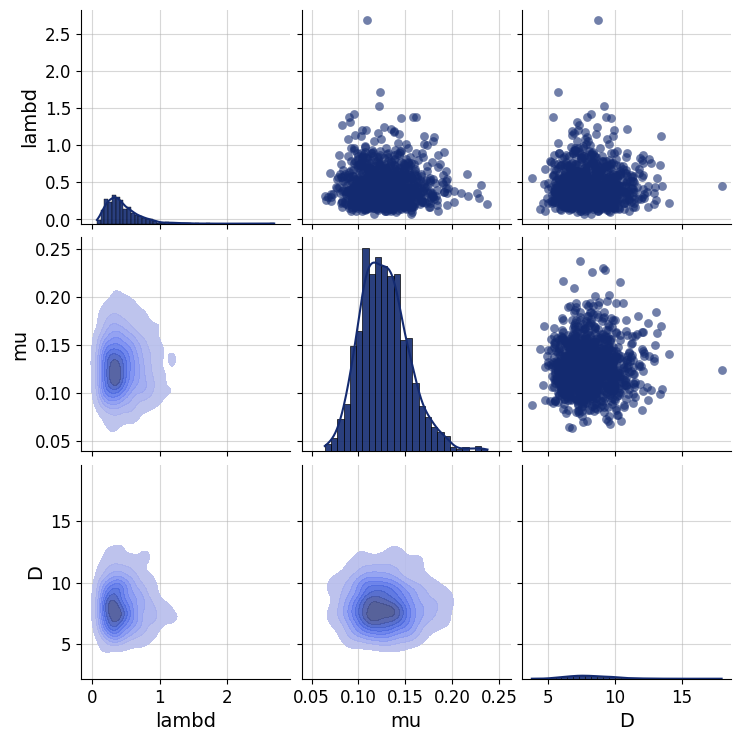

In [8]:
prior_samples = simulator.simulators[0].sample(1000)

grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["lambd", "mu", "D"]
)

In [9]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("cases")
    .concatenate(["lambd", "mu", "D", "I0", "psi"], into="inference_variables")
    .rename("cases", "summary_variables")
    # since all our variables are non-negative (zero or larger), the next call transforms them
    # to the unconstrained real space and can be back-transformed under the hood
    .log(["inference_variables", "summary_variables"], p1=True)
)

In [10]:
adapter

Adapter([0: ConvertDType -> 1: AsTimeSeries -> 2: Concatenate(['lambd', 'mu', 'D', 'I0', 'psi'] -> 'inference_variables') -> 3: Rename('cases' -> 'summary_variables') -> 4: Log])

In [11]:
# Let's check out the new shapes
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(2, 14, 1)
(2, 5)


In [12]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary
summary_net = GRU()

In [13]:
inference_net = bf.networks.CouplingFlow()

In [14]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    standardize=None # no need to standardize due to log-transform
)

In [15]:
training_data = workflow.simulate(6000)
validation_data = workflow.simulate(300)

In [16]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=100, 
    batch_size=64, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 9.1371 - val_loss: 3.0354
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.0082 - val_loss: -1.3838
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -1.7179 - val_loss: -2.2866
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.1889 - val_loss: -2.4933
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.3873 - val_loss: -2.2758
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.3728 - val_loss: -1.9796
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.5379 - val_loss: -1.5978
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -2.6286 - val_loss: -2.1454
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -2.6848 - val_loss: -2.7305
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.7169 - val_loss: -3.0875
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -2.8222 - val_loss: -1.6012
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1

INFO:bayesflow:Training completed in 1.22 minutes.
